In [1]:
# 필요한 라이브러리 설치
!pip install transformers datasets matplotlib seaborn evaluate accelerate scikit-learn

# 라이브러리 임포트
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np

# MNLI 데이터셋 로드
dataset = load_dataset("nyu-mll/glue", "mnli")

# 데이터 전처리: 모델에 맞게 토크나이징
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding=True)

# 'train' 데이터셋만 사용하고, 전처리 적용
train_dataset = dataset["train"].map(preprocess_function, batched=True)
train_dataset = train_dataset.select(range(20000))  # 첫 2만 개 샘플만 사용

# 'validation_matched'를 validation dataset으로 사용
eval_dataset = dataset["validation_matched"].map(preprocess_function, batched=True)

# 모델 로드: BERT 모델을 fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# 데이터셋의 예시 확인
print(train_dataset[0])

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'hypothesis': 'Product and geography are what make cream skimming work. ', 'label': 1, 'idx': 0, 'input_ids': [101, 28103, 14795, 7081, 10458, 25004, 1144, 1160, 3501, 10082, 118, 3317, 1105, 14534, 119, 102, 22249, 1105, 14534, 1132, 1184, 1294, 7081, 10458, 25004, 1250, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1

In [3]:
# Trainer의 인자 설정

training_args = TrainingArguments(
    output_dir="./results",              # 결과를 저장할 디렉토리
    evaluation_strategy="epoch",         # 에포크마다 평가
    save_strategy="epoch",               # 에포크마다 모델 저장
    num_train_epochs=7,                  # 학습 에포크 수
    per_device_train_batch_size=8,       # 학습 배치 사이즈
    per_device_eval_batch_size=8,        # 평가 배치 사이즈
    warmup_steps=500,                    # 워밍업 스텝
    weight_decay=0.01,                   # 가중치 감소
    logging_dir="./logs",                # 로그 저장 위치
    logging_steps=10,                    # 로그를 기록할 스텝
    load_best_model_at_end=True,         # 최적 모델을 마지막에 로드
    metric_for_best_model="accuracy",   # 최적 모델을 평가할 기준
    greater_is_better=True               # 정확도가 높을수록 좋은 모델로 간주
)


# 평가 함수 정의 (accuracy 계산)
accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)  # 예측값을 최댓값으로 선택
    return accuracy.compute(predictions=predictions, references=labels)

/opt/miniconda3/envs/nabakgood/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [4]:
import random
# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# 모델 학습 시작
trainer.train()

# 학습 후 성능 평가 (validation_matched에 대해)
eval_results = trainer.evaluate(eval_dataset)

# 성능 출력
print("Validation Accuracy:", eval_results["eval_accuracy"])


/var/folders/wp/4st9875572q0w_v809kcp7dw0000gn/T/ipykernel_52775/533343380.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.891800,0.687151,0.716251
2,0.782600,0.760584,0.705553
3,0.363900,1.041715,0.736831
4,0.114400,1.322799,0.733673
5,0.194300,1.561323,0.743658
6,0.000400,1.881474,0.742333
7,0.001000,1.959710,0.744065


Validation Accuracy: 0.7440652063168619


성능이 50% 이상을 달성했습니다!


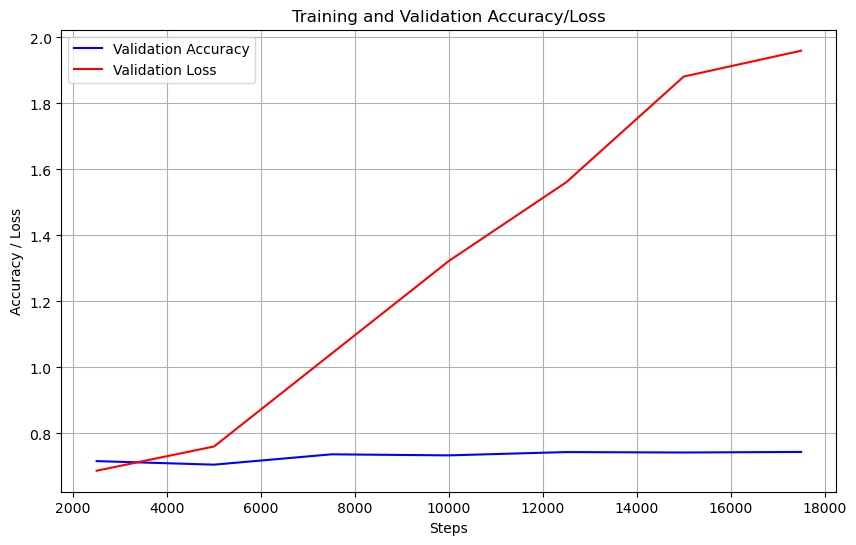

In [5]:

# 만약 성능이 50% 이상을 넘겼다면 출력
if eval_results["eval_accuracy"] > 0.5:
    print("성능이 50% 이상을 달성했습니다!")
else:
    print("성능이 50% 이하입니다.")

# 결과 시각화: 학습과 평가 정확도 그래프
logs = trainer.state.log_history
train_acc = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]
train_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
steps = [log['step'] for log in logs if 'eval_accuracy' in log]

# 학습 및 평가 정확도 시각화
plt.figure(figsize=(10, 6))
plt.plot(steps, train_acc, label="Validation Accuracy", color='blue')
plt.plot(steps, train_loss, label="Validation Loss", color='red')
plt.xlabel("Steps")
plt.ylabel("Accuracy / Loss")
plt.title("Training and Validation Accuracy/Loss")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
device = torch.device("cpu")
model.to(device)

# 예시 문장 100개 예측: 예시 문장과 라벨 예측 출력
def get_predictions(num_examples=100):
    # 예시 문장 100개 추출
    examples = eval_dataset.select(range(num_examples))
    inputs = tokenizer(examples["premise"], examples["hypothesis"], padding=True, truncation=True, return_tensors="pt")

    # 모델을 평가 모드로 설정
    model.eval()

    # 예측을 위한 input_ids를 모델에 전달
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # 예측 확률
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # 예측 결과 라벨과 확률을 추출
    predicted_labels = torch.argmax(probs, dim=-1).numpy()
    predicted_scores = probs.max(dim=-1).values.numpy()

    # 예시 문장과 예측 결과 출력
    label_map = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}

    predictions = []
    for i in range(num_examples):
        pred_label = label_map[predicted_labels[i]]
        score = predicted_scores[i]
        premise = examples["premise"][i]
        hypothesis = examples["hypothesis"][i]
        predictions.append((premise, hypothesis, pred_label, score))

    return predictions

# 예시 문장 100개 예측 출력
predictions = get_predictions(100)

# 예시 출력
for i, (premise, hypothesis, label, score) in enumerate(predictions[:10]):
    print(f"{i+1}. Premise: {premise}")
    print(f"   Hypothesis: {hypothesis}")
    print(f"   Predicted Label: {label} (Score: {score:.4f})\n")

1. Premise: The new rights are nice enough
   Hypothesis: Everyone really likes the newest benefits 
   Predicted Label: Neutral (Score: 1.0000)

2. Premise: This site includes a list of all award winners and a searchable database of Government Executive articles.
   Hypothesis: The Government Executive articles housed on the website are not able to be searched.
   Predicted Label: Contradiction (Score: 0.9999)

3. Premise: uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him
   Hypothesis: I like him for the most part, but would still enjoy seeing someone beat him.
   Predicted Label: Entailment (Score: 0.9998)

4. Premise: yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food
   Hypothesis: My favorite restaurants are always at least a hundred miles away from my house. 
   Predicted Label: Neutral (Score: 0

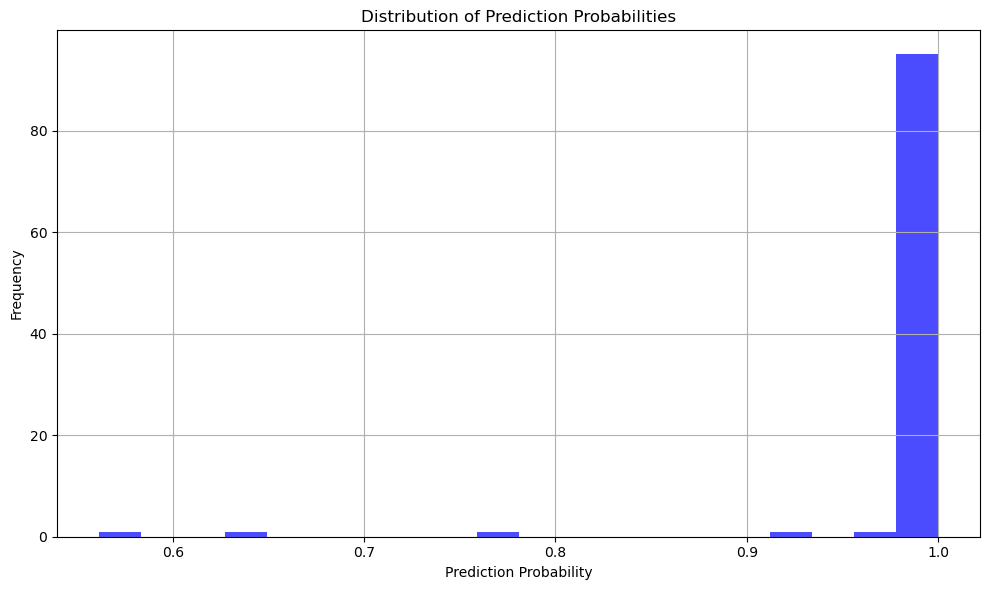

In [38]:
def plot_probability_distribution(predictions):
    # 예측 확률 값 추출
    prob_values = np.array([pred[3] for pred in predictions])  # 예측 확률 값 (score)

    # 히스토그램 그리기
    plt.figure(figsize=(10, 6))
    plt.hist(prob_values, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Probabilities')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 예측 확률 분포 시각화
plot_probability_distribution(predictions)
